In [23]:
import numpy as np
import pandas as pd
from scipy.special import gammaln, gamma
from collections import Counter
from scipy.optimize import basinhopping
np.set_printoptions(suppress=True)
%matplotlib inline
import matplotlib.pyplot as plt

In [73]:
# Load the data and process it.

df = pd.read_csv("../mturk_surveys.csv")
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df['date'] = pd.to_datetime(df['hit_answered_date'].apply(lambda x : x.date()))

# Calculate the time period of each survey answer. 
# Below we take out time period to be 30-day periods. 
# We can change this to be weeks, months, or anything else
window_length = 30
minDate = min(df['date'])
df['period'] = (df['date'] - minDate).dt.days // window_length 

#df = df[df['period'] < 10]
# Create a list of all unique worker IDs 
workers = pd.DataFrame(list(set(df.worker_id)), columns=['worker_id']).reset_index().set_index('worker_id')

# Fix the issue of duplicate records within the same period.
data = df[['worker_id', 'period']].drop_duplicates().pivot_table(
    index = 'worker_id',
    values = 'period',                    
    aggfunc=('count','min','max')
).join(workers).set_index('index').sort_index()

# Aggregate the capture histories
data = data.groupby(['min', 'count']).size().reset_index(name='count_history')
S = df['period'].max() + 1
dat = np.zeros(S + 1)
out = Counter(data['count'].values)
for k,v in out.items():
    dat[k] = v
V = len(workers)
print(S, V)

36 46145


In [101]:
df.groupby('period').cumcount()

0            0
1            1
2            2
3            3
4            4
5            5
6            6
7            7
8            8
9            9
10          10
11          11
12          12
13          13
14          14
15          15
16          16
17          17
18          18
19          19
20          20
21          21
22          22
23          23
24          24
25          25
26          26
27          27
28          28
29          29
          ... 
103328    2795
103329    2796
103330    2797
103331    2798
103332    2799
103333    2800
103334    2801
103335    2802
103336    2803
103337    2804
103338    2805
103339    2806
103340    2807
103341    2808
103342    2809
103343    2810
103344    2811
103345    2812
103346    2813
103347    2814
103348    2815
103349    2816
103350    2817
103351    2818
103352    2819
103353    2820
103354    2821
103355    2822
103356    2823
103357    2824
Length: 103358, dtype: int64

<BarContainer object of 37 artists>

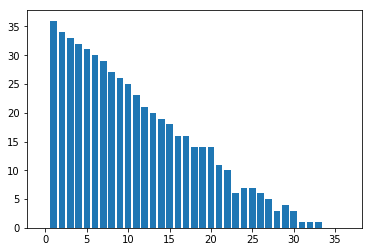

In [75]:
plt.bar(np.arange(S+1), dat)

In [76]:
data[(data['min'] == 1) & (data['count'] == 32)]

,min,count,count_history


,min,count,count_history
490,25,1,700
491,25,2,147
492,25,3,53
493,25,4,33
494,25,5,22
495,25,6,12
496,25,7,1
497,25,8,2
498,25,9,2


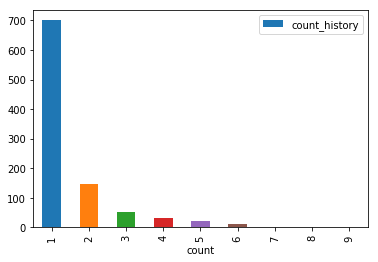

In [95]:
data[data['min'] == 25].sort_values(['min', 'count']).plot(x = 'count', y = 'count_history', kind = 'bar')
data[data['min'] == 25].sort_values(['min', 'count'])

In [3]:
def mll(initParams):
    # params
    f0    = initParams[0]
    alpha = initParams[1]
    beta  = initParams[2]
    p     = initParams[3]
    mix   = initParams[4]
    
    # N! / f0!
    N = gammaln(V + f0 +1) - gammaln(f0 + 1)
    L0 = f0 * np.log( (mix * Bin(S, 0, p)) +  ((1 - mix) * BB(S, 0, alpha, beta)) )
    Lk = 0
    
    # fk likelihood
    for k in range(1, len(dat)):
        Lk += dat[k] * np.log(  (mix * Bin(S, k, p)) +  ((1 - mix) * BB(S, k, alpha, beta)) )
    
    obj = N + L0 + Lk
    print(mix, p, alpha, beta, f0, -obj, N, L0, Lk, BB(S, 0, alpha, beta) )
    return -obj

In [17]:
# Alpha Beta version
def BB(S, k, alpha, beta):
    up = gamma(k + alpha) * gamma(S - k + beta) * gamma(alpha + beta)
    down = gamma(alpha) * gamma(beta) * gamma(S + alpha + beta)
    return up / down

def Bin(S, k, prob):
    Bi= k* np.log(prob) + (S-k) * np.log(1-prob)
    return np.exp(Bi)

In [18]:
def mll(initParams):
    # params
    f0 = initParams[0]
    alpha = initParams[1]
    beta = initParams[2]
    p = initParams[3]
    mix = initParams[4]
    
    # N! / f0!
    N = gammaln(V + f0 +1) - gammaln(f0 + 1)
    L0 = f0 * np.log(  (mix * Bin(S, 0, p)) +  ((1 - mix) * BB(S, 0, alpha, beta)))
    Lk = 0
    
    # fk likelihood
    for k in range(1, len(dat)):
        Lk += dat[k] * np.log(  (mix * Bin(S, k, p)) +  ((1 - mix) * BB(S, k, alpha, beta)))
    
    obj = N + L0 + Lk
    #if -obj < -10000:
    #    print(f0, alpha, beta, p, mix, -obj)
    return -obj

In [37]:
# Bounds
B= ((1000,100000), (0.3, 10), (2, None), (0.5, 1), (0.01,1))

#args
minimizer_kwargs = dict(method="L-BFGS-B", bounds=B)

#run
initParams = np.array([10000, 2, 5, .5, .8])
res = basinhopping(mll, initParams, minimizer_kwargs=minimizer_kwargs)
print(res)
print(res['x'][0] + V)

/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.p

                        fun: nan
 lowest_optimization_result:       fun: nan
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  -0.12514647,   52.91658454,   -7.15954229, -382.2700819 ,
       1179.01217891])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 648
      nit: 39
   status: 2
  success: False
        x: array([10000.25762527,     8.23930108,    86.84357609,     0.55497967,
           0.03809816])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 85
                       nfev: 23166
                        nit: 100
                          x: array([10000.25762527,     8.23930108,    86.84357609,     0.55497967,
           0.03809816])
27898.257625265032


In [13]:
# Bounds
B= ((1,14), (0, 0.1), (0, 5), (0, .001), (0,1))

#args
minimizer_kwargs = dict(method="L-BFGS-B", bounds=B)

#run
initParams = np.array([1, .12, 5, .0005, .8])
res = basinhopping(mll, initParams, minimizer_kwargs=minimizer_kwargs, niter = 50000)
print(res)
print(np.exp(res['x'][0]) + V)

/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
/Users/ded/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


KeyboardInterrupt: 

In [61]:
mll([403608.7895533 ,      0.02039742,      3.7429387 ,      0.01037844,
            0.20782324])

-121061.20699431212

In [62]:
mll([83793.7773379 ,     0.19999895,     4.07278073,     0.01197954,
           0.70142692])

-120977.7095533876

In [64]:
mll([234776.72579006,      0.03929604,      3.78447354,      0.01050833,
            0.33356468])

-121053.78927293565

In [67]:
mll([57392.28189185,     0.38756928,     4.32406151,     0.01459061,
           0.80091354])

-120812.86576105905

In [114]:
mll([125104.16766101,      0.09702091,      3.89744013,      0.01093061,
            0.54677371])

-121029.53788561595

In [188]:
mll([11.03010376,  1.1       ,  6.66479873,  0.01335952,  0.89314851])

-120587.12622553745

In [202]:
mll([11.736900670364296,      0.09702091,      3.89744013,      0.01093061, 0.54677371])

125104.00000000009 0.09702091 3.89744013 0.01093061 0.54677371 -121029.53779149149


-121029.53779149149

In [38]:
mll([10000.25762527,     8.23930108,    86.84357609,     0.55497967,
           0.03809816])

-87262.46893670881